In [1]:
#%%
import pandas as pd
from backtestlib import *
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import pickle
from datetime import datetime,date
import os
import matplotlib.pyplot as plt
# 设置字体为微软雅黑
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
start_date_true= '2023-01-01' 
end_date= date.today().strftime('%Y-%m-%d')
# end_date = '2024-12-31'
# end_date = '2024-11-20'
transaction_fee_rate=0.0000 # 0.03%
index_code = '000852.SH' 




def int_index_to_datetime(df):
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    return df

def adj_date(df, start_date=start_date_true, end_date=end_date):
    try:
        return df[(df.index>=start_date) & (df.index<=end_date)]
    except:
        raise Exception('Date must be integer and set as index.')

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2024 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


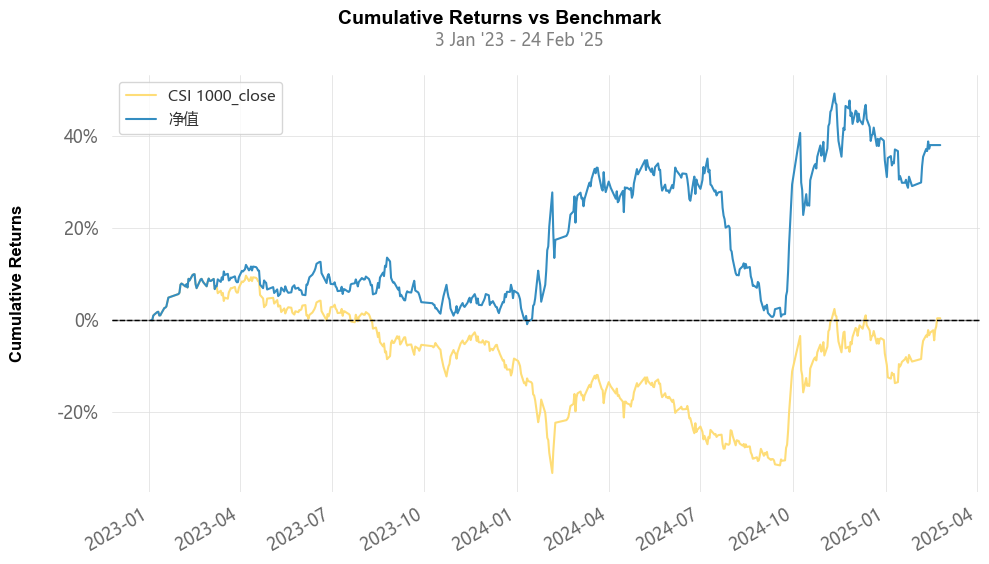

                                                        2023      2024  \
Annualized Return                                   0.044259  0.177246   
Annualized Volatility                               0.146746  0.334810   
Information Ratio                                   0.045752  0.037933   
Win Rate                                            0.524793  0.524793   
Maximum Drawdown Rate                              -0.110906 -0.254400   
Excess Net Value                                    0.147336  0.253824   
Annualized Excess Return                            0.092854  0.110883   
Excess Drawdown Level                              -0.137426 -0.273626   
Return Volatility Ratio                             0.301606  0.529391   
Return Drawdown Ratio                              -0.399069 -0.696721   
Longest Loss Duration (Months)                      4.200000  2.900000   
Loss Time Ratio                                     0.618749  0.380882   
Probability of Exceeding 10% Loss at 1

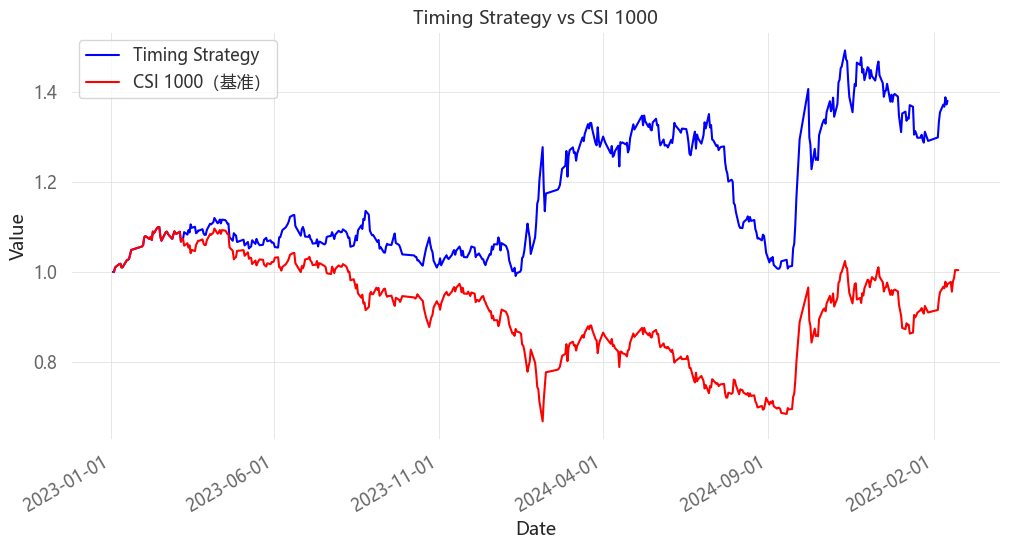

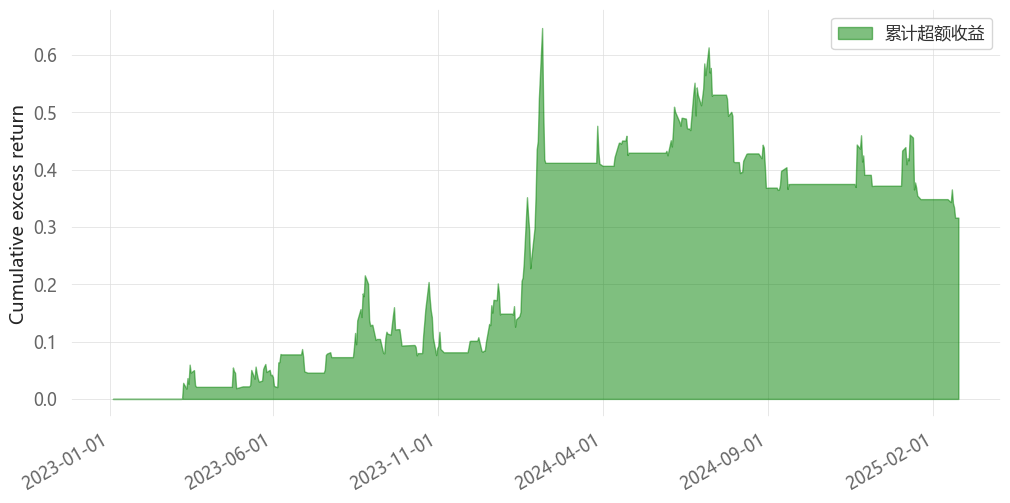

In [3]:
df_longshort = pd.read_excel(r'C:\QPS\Project\backtest\result_df.xlsx').set_index('date')




df_longshort = int_index_to_datetime(df_longshort) # read the data


# 初始化仓位
df_longshort['Position'] = 1.0  
df_longshort['transaction_fee']=0.0 
# Use Cluster to determine the position
for i in range(2, len(df_longshort)):
    if df_longshort['Cluster'].iloc[i-1]==1.0: # 输出值[0.4,1]
        df_longshort['Position'].iloc[i] = 1.0 
    elif df_longshort['Cluster'].iloc[i-1]==0 and df_longshort['Cluster'].iloc[i-2]==0:
        df_longshort['Position'].iloc[i] = -1.0
    else:
        df_longshort['Position'].iloc[i] = df_longshort['Position'].iloc[i-1]



# calculate transaction fee
for i in range(1, len(df_longshort)):
    previous_position = df_longshort.iloc[i-1]['Position']
    current_position = df_longshort.iloc[i]['Position']
    
    # 计算交易费用
    if previous_position != current_position:
        df_longshort['transaction_fee'].iloc[i] = transaction_fee_rate  * abs(current_position - previous_position)
        # df_longshort['transaction_fee'].iloc[i] = transaction_fee_rate
    else:
        df_longshort['transaction_fee'].iloc[i] = 0


strategy_longshort = backtest_longshort(start_date='2023-01-03', end_date=end_date,df_timing = df_longshort, index_code=index_code,positive = 0)
# strategy_longshort = backtest_longshort(start_date='2022-01-01', end_date=end_date,df_timing = df_longshort, index_code=index_code,positive = 0)
# 策略收益率和基准收益率
strategy_returns = strategy_longshort.df_merged['净值'].pct_change(1)
benchmark_returns = strategy_longshort.df_merged[f'{strategy_longshort.get_index_name(strategy_longshort.index_code)}_close'].pct_change(1)
risk_free_rate = 0.02  # 假设年化无风险利率为2%

# 调用analyze_performance方法来分析表现
performance_metrics = strategy_longshort.analyze_performance(strategy_returns, benchmark_returns, risk_free_rate)
result = strategy_longshort.calculate_performance()
print(result)